In [1]:
import seaborn as sns
import concurrent.futures
import argparse
import numpy as np
import subprocess
import os
from pathlib import Path
from typing import List, Optional
import json
import pandas as pd
from collections import defaultdict
import yaml
import json
import gin
from typing import Dict, Any, Callable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from PIL import Image
import plotly.graph_objects as go

import lib_analysis
import lib_biased_mnist
import lib_toy
import lib_problem

gin.enter_interactive_mode()

In [2]:
def l2_probability_distance(y_hat: tf.Tensor) -> tf.Tensor:
    return tf.reduce_sum((y_hat[:,0,:] - y_hat[:, 1, :])**2.0, axis=-1)

def l1_probability_distance(y_hat: tf.Tensor) -> tf.Tensor:
    return tf.reduce_sum(tf.abs(y_hat[:,0,:] - y_hat[:, 1, :]), axis=-1)

In [3]:
def process_dataset(
    dataset: tf.data.Dataset, models: List[tf.keras.Model]
) -> tf.Tensor:
    Xs = []
    true_labels = []
    predicted = []
    biased_labels = []
    for X, y, y_biased in dataset.batch(256):
        Xs.append(X)
        (features, ys_pred) = lib_problem.forward(X, y, models)
        probabilities = tf.nn.softmax(ys_pred)
        true_labels.append(y)
        biased_labels.append(y_biased)
        predicted.append(probabilities)
    Xs = tf.concat(Xs, axis=0)
    true_labels = tf.cast(tf.concat(true_labels, axis=0), tf.int32)
    biased_labels = tf.cast(tf.concat(biased_labels, axis=0), tf.int32)
    predicted = tf.transpose(tf.concat(predicted, axis=1), perm=[1, 0, 2])
    return Xs, true_labels, biased_labels, predicted

In [4]:
def plot_digit_grid(X: tf.Tensor, y: tf.Tensor, per_digit: int = 10):
    f, axarr = plt.subplots(per_digit, 10)

    for i in range(10):
        x = X[y == i]
        if x.shape[0] == 0:
            print(f'Could not find any images with label {i}! Skipping...')
            continue
        indices = np.random.choice(x.shape[0], size=per_digit)
        for j in range(per_digit):
            axarr[j, i].imshow(x[indices[j]] * 0.5 + 0.5)
            axarr[j, i].axis("off")

    plt.show()
    
def plot_biased_digit_grid(X: tf.Tensor, y: tf.Tensor, y_biased: tf.Tensor):
    n_digits = len(np.unique(y))
    
    f, axarr = plt.subplots(10, n_digits)

    for i in range(n_digits):
        for j in range(10):
            x = X[(y == i) & (y_biased == j)]
            if x.shape[0] == 0:
                print(f'Could not find any images with label {i} and bias {j}! Skipping...')
                continue
            indices = np.random.choice(x.shape[0], size=1)
            axarr[j, i].imshow(x[indices[0]] * 0.5 + 0.5)
            axarr[j, i].axis("off")

    plt.show()

In [5]:
from plotly.colors import n_colors
colors = n_colors('rgb(200, 200, 250)', 'rgb(250, 200, 200)', 101, colortype='rgb')
colors = np.array(colors)


def pretty_print_matrix(matrix: np.ndarray):
    bgs = matrix.shape[1]

    header_values = ["image digit"] + [f"bg-color-{i}" for i in range(bgs)]

    n_rows = matrix.shape[0]
    n_cols = matrix.shape[1]

    values_of_column = np.ndarray(
        (n_cols, n_rows),
        dtype=object
    )
    percentages = np.ndarray(
        (n_cols, n_rows),
        dtype=float
    )
    
    for i in range(n_rows):
        for j in range(n_cols):
            (correct, total) = matrix[i, j, :]
            if total > 0:
                percent = correct / total * 100
            else:
                percent = 0
                
            percentages[j][i] = percent
            values_of_column[j][i] = f"{correct} / {total} ({percent:.2f}%)"
                        
    percentages = np.around(percentages).astype(np.int32)
    
    fill_color = []
    
    for col in percentages:
        add = colors[col]
        fill_color.append(add)

    row_legend = np.asarray([str(i) for i in range(n_rows)])[np.newaxis, :]
    
    fig = go.Figure(
        data=[
            go.Table(
                header=dict(
                    values=header_values,
                    line_color="darkslategray",
                    fill_color="lightskyblue",
                    align="left",
                ),
                cells=dict(
                    values=np.concatenate([row_legend, values_of_column], axis=0),
                    line_color="darkslategray",
                    fill_color=[["lightskyblue"] * n_rows] + fill_color,
                    align="left",
                ),
            )
        ]
    )
    
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=0, pad=0),
        paper_bgcolor="LightSteelBlue",
    )
    fig.update_layout(width=1000, height=150)
    fig.update_yaxes(automargin=True)
    fig.show()

In [6]:
def for_one_confusion_matrix(
    X: tf.Tensor, y: tf.Tensor, y_biased: tf.Tensor, y_label_hat: tf.Tensor
):
    assert X.shape[0] == y.shape[0]
    assert X.shape[0] == y_biased.shape[0]
    assert X.shape[0] == y_label_hat.shape[0]

    digits = np.unique(y)
    backgrounds = list(range(10))

    digit_accuracy_matrix = np.ndarray(
        ((np.max(digits) + 1), len(backgrounds)), dtype=(int, 2)
    )

    bias_matrix = np.ndarray(((np.max(digits) + 1), len(backgrounds)), dtype=(int, 2))

    for i in digits:
        for j in backgrounds:
            select = (y == i) & (y_biased == j)
            total_entries = tf.math.count_nonzero(select)
            accuracy = tf.math.count_nonzero(y_label_hat[select] == y[select])
            bias = tf.math.count_nonzero(y_label_hat[select] == y_biased[select])
            digit_accuracy_matrix[i, j] = (accuracy, total_entries)
            bias_matrix[i, j] = (bias, total_entries)
    return digit_accuracy_matrix, bias_matrix



def render_confusion_matrices(
    X: tf.Tensor,
    y: tf.Tensor,
    y_biased: tf.Tensor,
    y_label_hat: tf.Tensor,
    models: List[int] = [0, 1],
    differences: bool = False,
):
    assert X.shape[0] == y.shape[0]
    assert X.shape[0] == y_biased.shape[0]
    assert X.shape[0] == y_label_hat.shape[0]
    models_confusion_matrix = [
        for_one_confusion_matrix(X, y, y_biased, y_label_hat[:, im]) for im in [0, 1]
    ]
    
    for im in models:
        print(f"Model {im}:")
        print(f"\tPredicted digit:")
        pretty_print_matrix(models_confusion_matrix[im][0])
        print(f"\tPredicted bg:")
        pretty_print_matrix(models_confusion_matrix[im][1])

    if differences:
        print("Differences: ")
        print("\tDigit:")
        pretty_print_df(
            pd.DataFrame(
                np.absolute(
                    models_confusion_matrix[0][0] - models_confusion_matrix[1][0]
                )
            )
        )
        print("\tBg:")
        pretty_print_df(
            pd.DataFrame(
                np.absolute(
                    models_confusion_matrix[0][1] - models_confusion_matrix[1][1]
                )
            )
        )


#render_confusion_matrices(
#    oo_X, oo_y, oo_y_biased, tf.argmax(oo_y_hat, axis=-1, output_type=tf.int32)
#)

In [10]:
def print_statistics(
    X: tf.Tensor,
    y: tf.Tensor,
    y_biased: tf.Tensor,
    y_hat: tf.Tensor,
    print_digits: bool = False,
    print_confusion_matrices: bool = False,
):
    y_label_hat = tf.argmax(y_hat, axis=-1, output_type=tf.int32)
    select = y_label_hat[:, 0] != y_label_hat[:, 1]

    def print_resume_stats(d: tf.Tensor):
        print(f"\t\tAverage probability distance: {tf.reduce_mean(d)}")
        for q in [99, 90, 25, 10, 1]:
            print(f"\t\t{q}% percentile: {tfp.stats.percentile(d, q)}")

    if print_confusion_matrices:
        print("\tOverall:")
        render_confusion_matrices(X, y, y_biased, y_label_hat)

    d = l2_probability_distance(y_hat[select])
    print("\tOn disagreement:")

    if d.shape == 0:
        print("\t\tNo disagreement!")
    else:
        print(
            f"\t\tTotal % of data: {tf.math.count_nonzero(select)} / {y.shape[0]} ({tf.math.count_nonzero(select) / y.shape[0] * 100:.2f}%)"
        )
        for im in [0, 1]:
            acc = tf.math.count_nonzero(
                y_label_hat[select][:, im] == y[select]
            ) / tf.math.count_nonzero(select)
            print(f"\t\tModel {im} accuracy: {acc * 100:.2f}%")
        print_resume_stats(d)

        if print_digits:
            plot_digit_grid(X[select], y[select])
        if print_confusion_matrices:
            render_confusion_matrices(
                X[select], y[select], y_biased[select], y_label_hat[select]
            )

    acc = y_label_hat[~select][:, 0] == y[~select]
    correct = tf.math.count_nonzero(acc)
    total = tf.math.count_nonzero(~select)
    acc = correct / total

    print("\tOn agreement:")
    print(f"\t\tTotal % of data: {tf.math.count_nonzero(~select) / y.shape[0]}")
    print(f"\t\tAccuracy: {acc}")
    d = l2_probability_distance(y_hat[~select])
    print_resume_stats(d)

    if print_digits:
        plot_digit_grid(X[~select], y[~select])
    if print_confusion_matrices:
        render_confusion_matrices(
            X[~select], y[~select], y_biased[~select], y_label_hat[~select], models=[0]
        )

On OOD:
	Overall:
Model 0:
	Predicted digit:


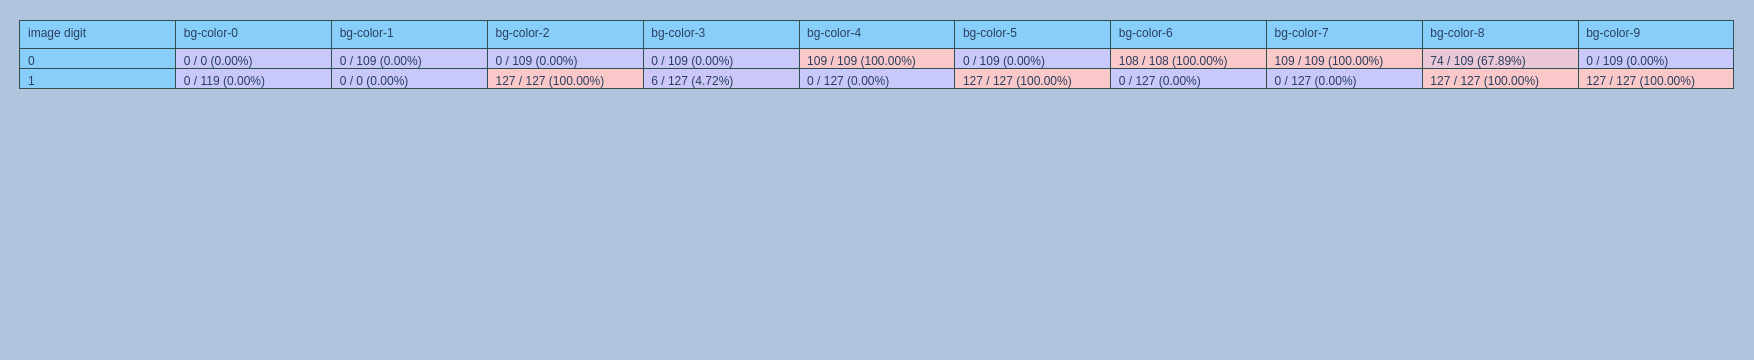

	Predicted bg:


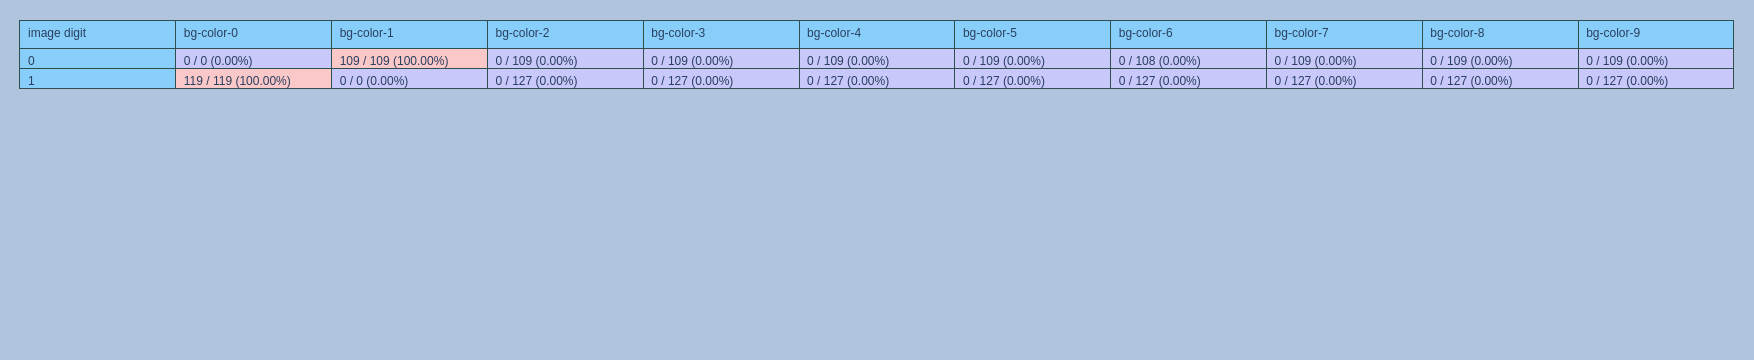

Model 1:
	Predicted digit:


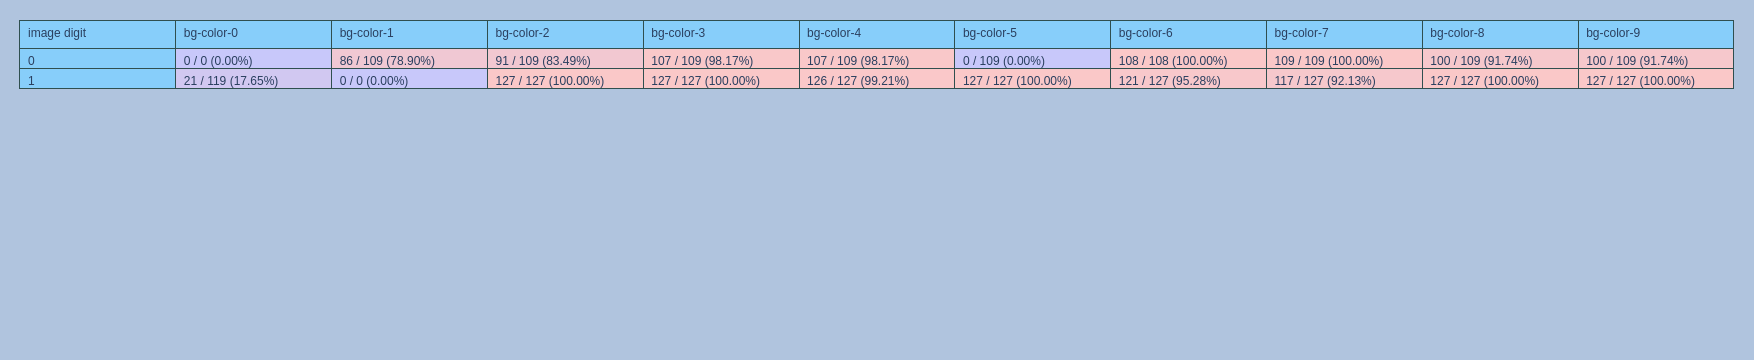

	Predicted bg:


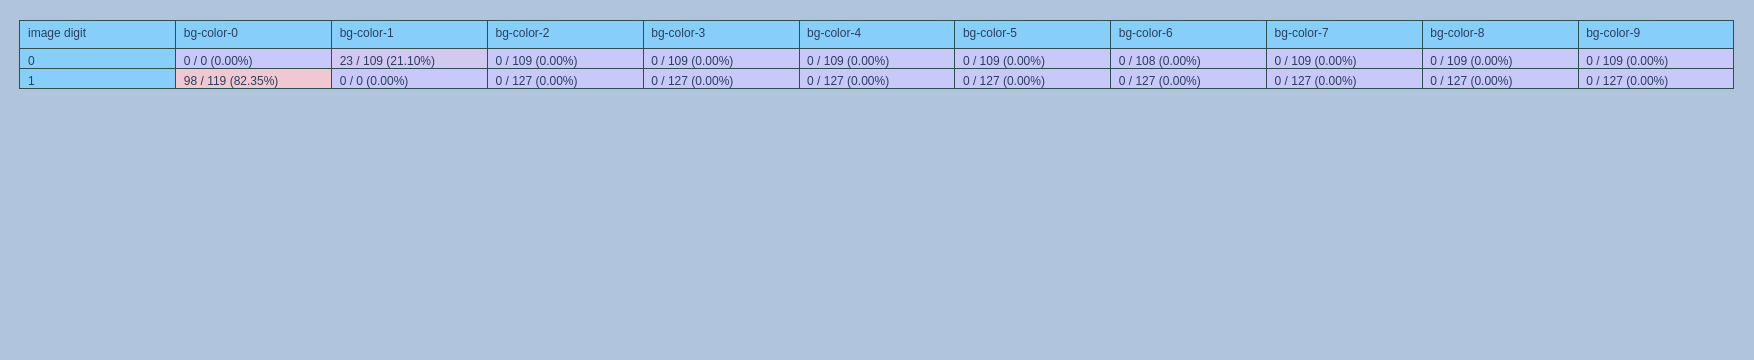

	On disagreement:
		Total % of data: 924 / 2115 (43.69%)
		Model 0 accuracy: 0.54%
		Model 1 accuracy: 99.46%
		Average probability distance: 1.3344393968582153
		99% percentile: 1.9972035884857178
		90% percentile: 1.9324252605438232
		25% percentile: 0.9024012088775635
		10% percentile: 0.6646164059638977
		1% percentile: 0.46733933687210083
Model 0:
	Predicted digit:


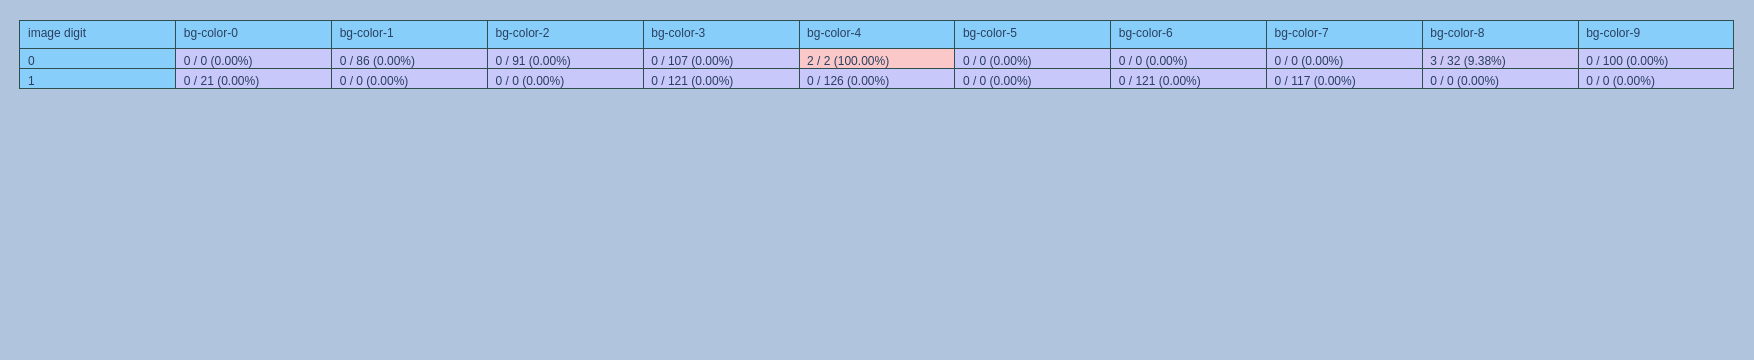

	Predicted bg:


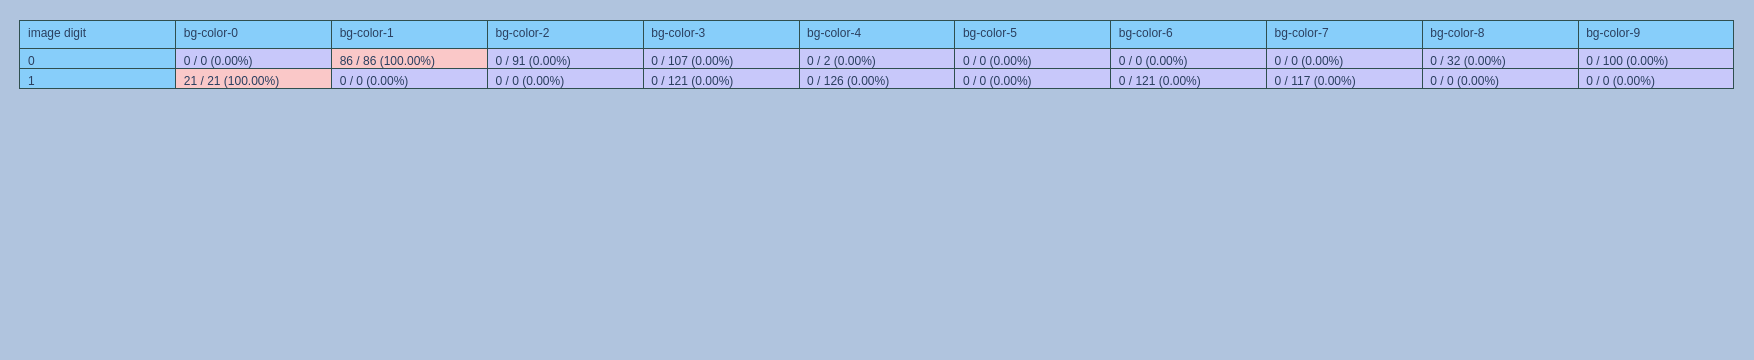

Model 1:
	Predicted digit:


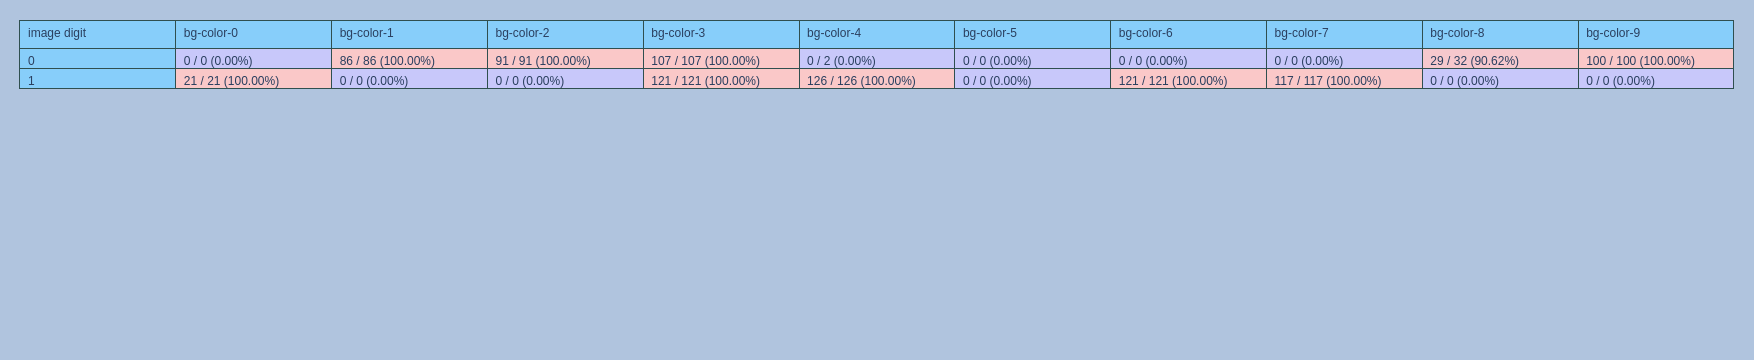

	Predicted bg:


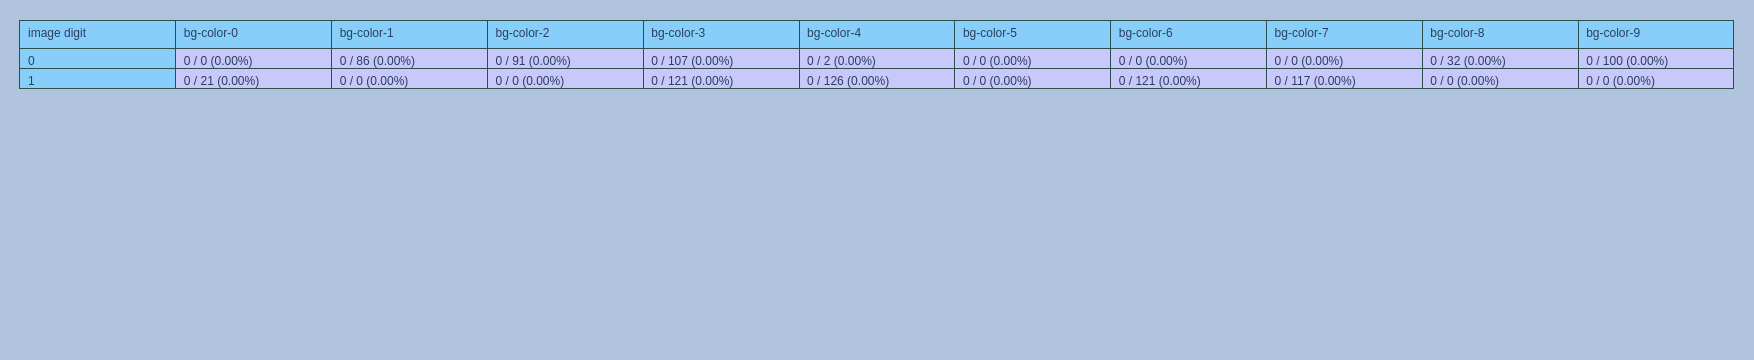

	On agreement:
		Total % of data: 0.5631205673758866
		Accuracy: 0.7632241813602015
		Average probability distance: 0.029576599597930908
		99% percentile: 0.4507773816585541
		90% percentile: 0.09677445888519287
		25% percentile: 2.2813290456724644e-07
		10% percentile: 1.0736139895942826e-13
		1% percentile: 3.18362821999027e-14
Model 0:
	Predicted digit:


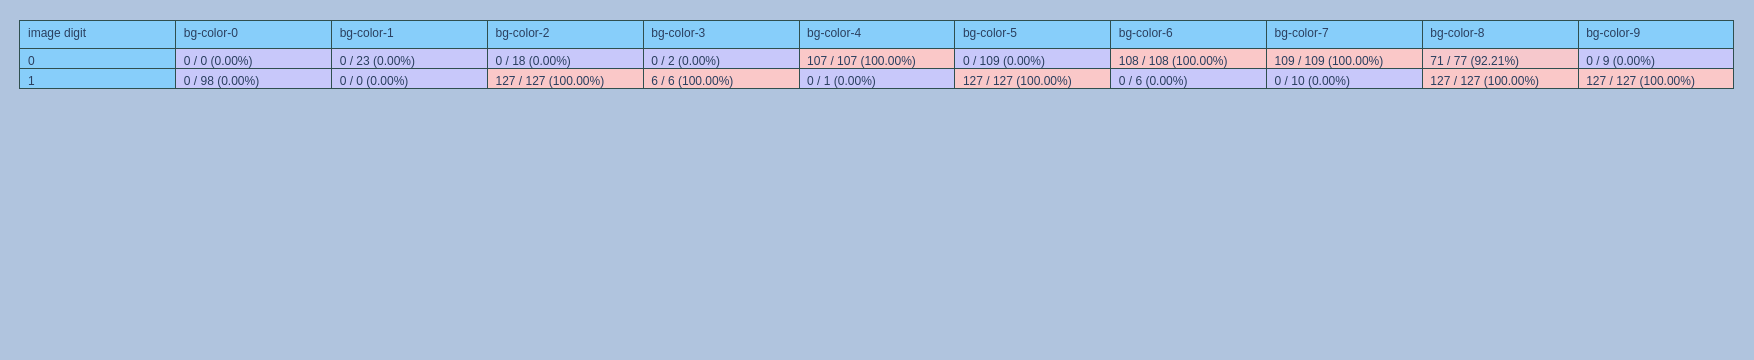

	Predicted bg:


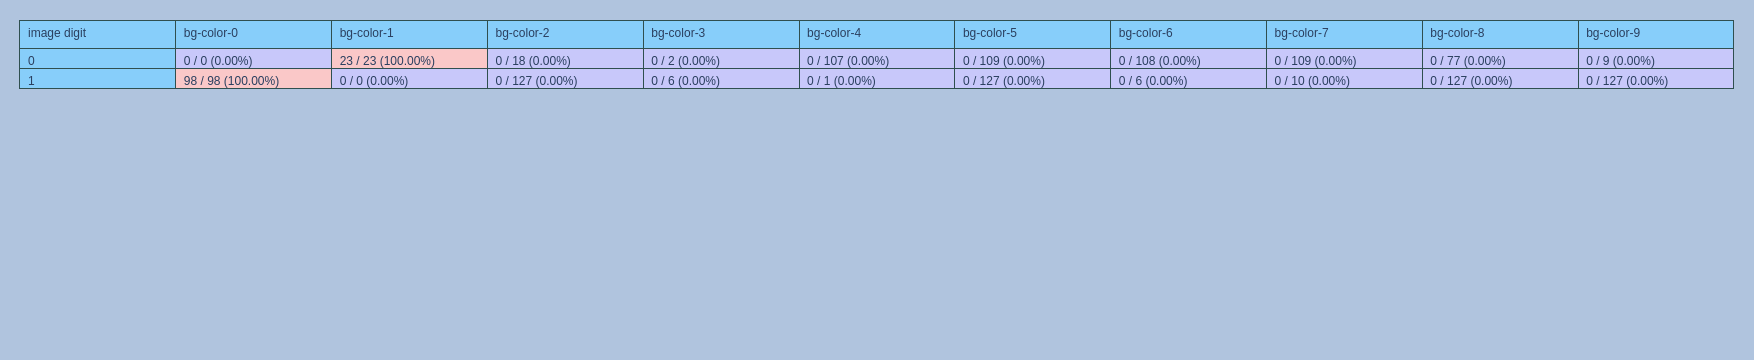

In [11]:
DF = lib_analysis.read_problem(Path('.'), '.')

df = DF.sample(1).reset_index(drop=True)

gin.parse_config_file('config.gin')
tf.keras.backend.clear_session()


problem = lib_biased_mnist.BiasedMnistProblem()

in_dist = tf.data.Dataset.from_tensor_slices(
            problem.filter_tensors(*lib_biased_mnist.get_biased_mnist_data("~/.datasets/mnist/", 1.0, train=False))).cache()

oo_dist = tf.data.Dataset.from_tensor_slices(
            problem.filter_tensors(*lib_biased_mnist.get_biased_mnist_data("~/.datasets/mnist/", 0.0, train=False))).cache()

models = problem.models

for im, m in enumerate(models):
    for v in m.trainable_variables:
        w = df['weights'][0][str(im)]
        assert v.name in w
        v.assign(w[v.name])

in_X, in_y, in_y_biased, in_y_hat = process_dataset(in_dist, models)
oo_X, oo_y, oo_y_biased, oo_y_hat = process_dataset(oo_dist, models)

print('On OOD:')
print_statistics(oo_X, oo_y, oo_y_biased, oo_y_hat, print_confusion_matrices=True)


In [247]:
sel = ((oo_y == 0) & (oo_y_biased == 5))
oo_y_hat[sel][:5]

<tf.Tensor: shape=(5, 2, 2), dtype=float32, numpy=
array([[[9.1657064e-08, 9.9999988e-01],
        [7.7127374e-04, 9.9922872e-01]],

       [[9.1657064e-08, 9.9999988e-01],
        [7.7127374e-04, 9.9922872e-01]],

       [[9.1657064e-08, 9.9999988e-01],
        [7.7127374e-04, 9.9922872e-01]],

       [[9.1657064e-08, 9.9999988e-01],
        [7.7127374e-04, 9.9922872e-01]],

       [[9.1657064e-08, 9.9999988e-01],
        [7.7127374e-04, 9.9922872e-01]]], dtype=float32)>

In [66]:
if False:
    plot_biased_digit_grid(tf.concat([oo_X, in_X], 0), tf.concat([oo_y, in_y], 0), tf.concat([oo_y_biased, in_y_biased], 0))

In [67]:
if False:
    DF = lib_analysis.read_problem(Path('../data'), 'biased_mnist')

In [68]:
if False:

    tf.keras.backend.clear_session()

    problem = lib_biased_mnist.BiasedMnistProblem()

    models = problem.models


    in_dist = tf.data.Dataset.from_tensor_slices(
                problem.filter_tensors(*lib_biased_mnist.get_biased_mnist_data("~/.datasets/mnist/", 1.0, train=True))).cache()

    oo_dist = tf.data.Dataset.from_tensor_slices(
                problem.filter_tensors(*lib_biased_mnist.get_biased_mnist_data("~/.datasets/mnist/", 0.0, train=False))).cache()


    for lambda_ in [1, 4, 16, 64, 256, 1024]:
        print(f"lambda = {lambda_}")
        df = DF[
            (DF['lambda'] == lambda_) &
            (DF['indep'] == 'conditional_hsic') &
            (DF['kernel'] == 'rbf') &
            (DF['BiasedMnistProblem.training_data_label_correlation'] == 0.997)
        ].sample(1).reset_index(drop=True)

        for im, m in enumerate(models):
            for v in m.trainable_variables:
                w = df['weights'][0][str(im)]
                assert v.name in w, f"Mismatching weight {v.name}"
                v.assign(w[v.name])

        in_X, in_y, in_y_biased, in_y_hat = process_dataset(in_dist, models)
        oo_X, oo_y, oo_y_biased, oo_y_hat = process_dataset(oo_dist, models)

        print('On OOD:')
        print_statistics(oo_X, oo_y, oo_y_biased, oo_y_hat, print_confusion_matrices=True)

        print('On ID:')
        print_statistics(in_X, in_y, in_y_biased, in_y_hat)
        print('=' * 100)

Model 0


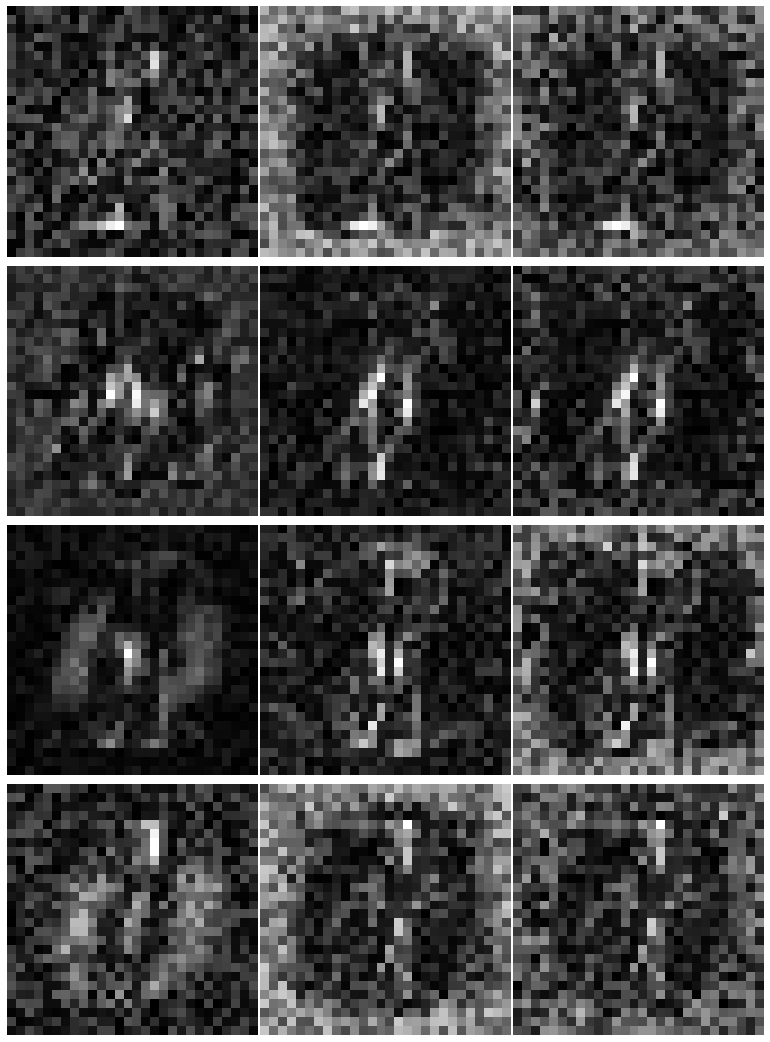

Model 1


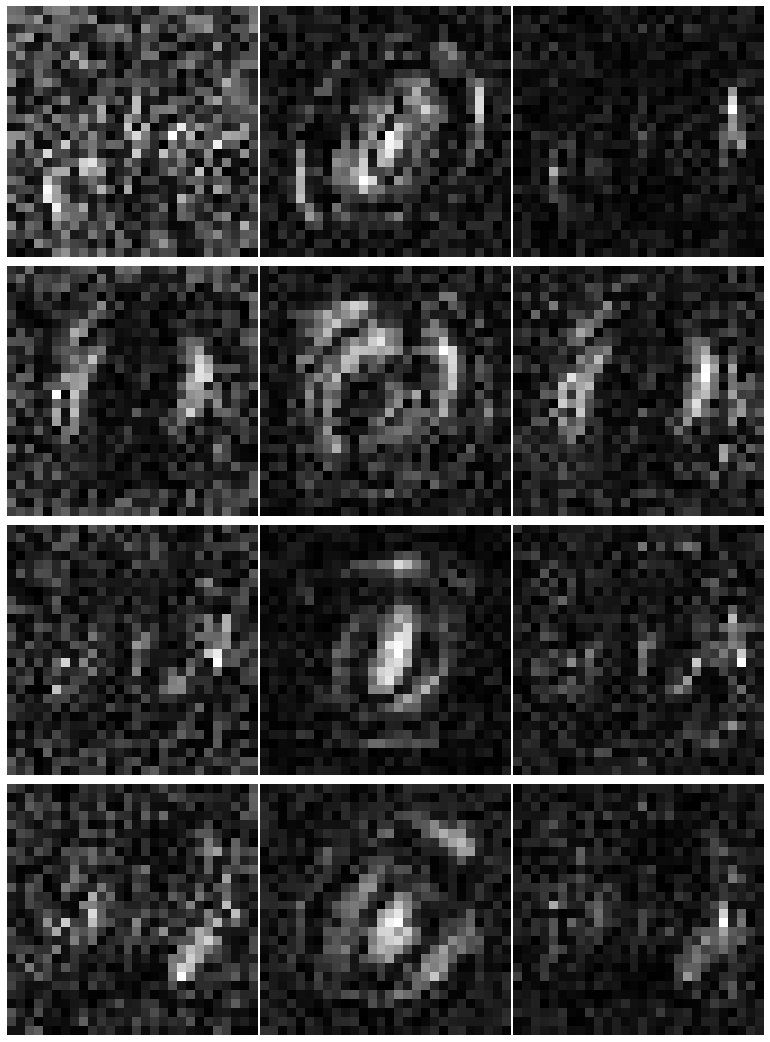

In [122]:
def visualize_weights(model: tf.keras.Model):
    (feature_extractor, logistic) = model.layers[-2:]
    [kernel, bias] = feature_extractor.get_weights()
    
    n_hidden_neurons = kernel.shape[-1]
    
    as_images = np.resize(kernel, (28, 28, 3, n_hidden_neurons))
    
    f, axarr = plt.subplots(n_hidden_neurons, 3, figsize=(15, 15))
    
    f.tight_layout()
    
    for i in range(n_hidden_neurons):
        for c in range(3):
            for_neuron = as_images[:, :, c, i]
            
            for_neuron = np.abs(for_neuron)

            axarr[i, c].imshow(for_neuron, cmap='gray')
            axarr[i, c].axis('off')

    plt.subplots_adjust(wspace=0.01, hspace=0.0001, right=10, left=9.3)
    plt.show()

print('Model 0')
visualize_weights(models[0])

print('Model 1')
visualize_weights(models[1])